In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import transformers
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

debug = False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.10.2+cu102
GPU:         		 NVIDIA GeForce GTX 1660 Ti
Memory Usage:	 0.5 GB /  2.7 GB


In [42]:
# Initializing parameters

batch_size = 256     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

sequence_max_length = 250

In [43]:
train_dataset, test_dataset = torchtext.datasets.IMDB(split=('train', 'test'))

In [44]:

from torchtext.data.functional import to_map_style_dataset

train_dataset = to_map_style_dataset(train_dataset)
test_dataset = to_map_style_dataset(test_dataset)

In [45]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# inputs

inputs = tokenizer.encode_plus(
                    'Hello, my dog is cute', 
                    None,
                    add_special_tokens=True,
                    max_length = 20,
                    truncation = True,
                    padding='max_length',
                    return_tensors="pt"               
                )

inputs

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [46]:
tokenizer.decode(inputs['input_ids'][0])

'[CLS] hello, my dog is cute [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [47]:
# dbert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
# res = dbert(inputs['input_ids'],inputs['attention_mask'])

In [48]:
# torch.mean(res.last_hidden_state, 1).shape

In [49]:
# print(dbert)



In [50]:
text_pipeline = lambda x: tokenizer.encode_plus(
                    x, 
                    None,
                    add_special_tokens=True,
                    max_length = sequence_max_length,
                    truncation = True,
                    padding='max_length'                    
                )
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [51]:
def collate_batch(batch):
     inputs = tokenizer.batch_encode_plus(
                    [text for _, text in batch],
                    add_special_tokens=True,
                    max_length = sequence_max_length,
                    truncation = True,
                    padding='max_length',
                    return_tensors="pt"                    
               )
     input_ids = inputs['input_ids']
     attention_mask = inputs['attention_mask']

     labels = torch.tensor([label_pipeline(label) for label, _ in batch], dtype=torch.float32).unsqueeze(-1)
     return (input_ids, attention_mask), labels

In [52]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=batch_size,
    collate_fn=collate_batch)

test_dataloader = DataLoader(
    test_dataset, 
    num_workers=8,
    batch_size=batch_size, 
    collate_fn=collate_batch)


In [53]:

for (input_ids, attention_masks), labels in train_dataloader:
    print("Shape of input_ids: ", input_ids.shape)
    print("Shape of attention_masks: ", attention_masks.shape)
    print("Labels : ", labels.shape)
    print("SAMPLE")
    print("Label: ",labels[0].item())
    print("Text:")
    print(tokenizer.decode(input_ids[0]))
    # print(X, y, o)
    break

Shape of input_ids:  torch.Size([256, 250])
Shape of attention_masks:  torch.Size([256, 250])
Labels :  torch.Size([256, 1])
SAMPLE
Label:  0.0
Text:
[CLS] i too like dafoe as an actor but i wasted a few hours of my life actually watching this film, i still cant believe i managed to watch it in its entirety. was there actually a point to the film?, and the ending, well, im glad i never paid to see this awful pointless piece of pathetic excuse of a film! < br / > < br / > im not sure without hunting the facts out but is dafoe married or seeing the awful actress in this film in real life, if so was it an attempt to kick start her career?, if so im afraid it must have failed.. < br / > < br / > i post this in the hope i can actually put someone off watching this film, even if 1 person takes heed of my comments and decides they would much rather watch paint drying i will feel i have made some good in the world, if only i had had the same advice... [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [54]:
from torch import nn

class ClassifyNet(nn.Module):

    def __init__(self, num_class):
        super().__init__()
        self.dbert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
        modules = [self.dbert.embeddings, *self.dbert.transformer.layer[:6]] #Replace 5 by what you want
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False

        self.fc = nn.Linear(768, num_class)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        x = self.dbert(input_ids, attention_mask)
        x = torch.mean(x.last_hidden_state, 1)
        
        x = self.dropout(x)
        # print(x.shape)
        x = self.fc(x)

        return torch.sigmoid(x)

In [55]:
a = torch.randn(32, 250, 16)
torch.mean(a, 1).shape

torch.Size([32, 16])

In [61]:
def train_loop(dataloader, model, loss_fn, optimizer, history, epoch):
    size = len(dataloader.dataset)
    accuracy = 0

    with tqdm(dataloader, unit="batch") as dl:
        for ((input_ids, attention_mask), y) in dl:
            dl.set_description(f"Training epoch {epoch}")

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)

            #FORWARD PASS
            pred = model(input_ids, attention_mask)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

            # if batch % 100 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    history['train_loss'].append(loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as dl:
            for ((input_ids, attention_mask), y) in dl:
                dl.set_description(f"Testing epoch {epoch}")   

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                y = y.to(device)


                pred = model(input_ids, attention_mask)
                
                loss += loss_fn(pred, y).item()
                accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [62]:
emsize = 16
num_classes = 1

model = ClassifyNet(num_classes).to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
print(model)

ClassifyNet(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featur

In [64]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count}")

Number of trainable parameters: 769


In [65]:
epochs = 10
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for epoch in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history, epoch)
    test_loop(test_dataloader, model, loss_fn, history)

# Base model has 66363649 parameters
# Takes 2 hours to train on a 1660 Gfx card
# 786.82s/epoch (11 minutes)

Training epoch 4:  27%|██▋       | 26/98 [01:34<04:22,  3.65s/batch]Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)

  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/pytho

KeyboardInterrupt: 

  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe


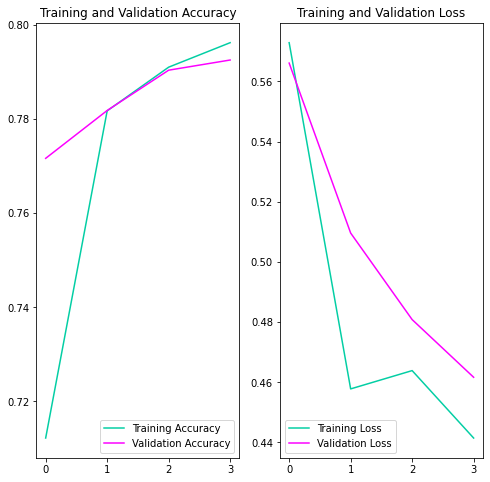

In [67]:
epochs_range = range(len(history['train_accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()
